In [1]:
import sys, os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch import optim
from collections import OrderedDict
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

Get files path and load data the data for visualization

In [3]:
training_path = "/content/drive/My Drive/Sussex AI/Spring Semester/Machine Learning/Kaggle Competition/training.csv"
additional_training_path = "/content/drive/My Drive/Sussex AI/Spring Semester/Machine Learning/Kaggle Competition/additional_training.csv"
testing_path = "/content/drive/My Drive/Sussex AI/Spring Semester/Machine Learning/Kaggle Competition/testing.csv"

In [4]:
training_data = pd.read_csv(training_path)
testing_data = pd.read_csv(testing_path)
additional_training_data = pd.read_csv(additional_training_path)

# Feature pre-processing and dataset creation

In [5]:
def get_split_tensors(add=False, method='mean', ts=0.25):
    
    # Read the csv files containing the training and test data
    training_data = pd.read_csv(training_path)
    testing_data = pd.read_csv(testing_path)
    
    # If the additional training is selected to be added
    if add:
        # Read the csv file containing the additional training datat 
        additional_training_data = pd.read_csv(additional_training_path)
        # Append the additional training 
        training_data = training_data.append(additional_training_data).reset_index(drop=True)
        # Shuffle the training data
        training_data = training_data.sample(frac=1).reset_index(drop=True)
        # Get all the features from the training data: don't select the id
        # column nor the predictions column
        features_training = training_data.iloc[:,1:-1]

        # Check which imputation method has been chosen
        if method == 'mean':    
            
            # Get prediction values
            targets_training = training_data['prediction'].values
            # Exapnd dimension of predicted values to match with the dimension 
            # of the predictions of the neural network    
            targets_training = np.expand_dims(targets_training, axis=-1)   

            # Apply simple imputator (mean in this case)
            imp = SimpleImputer(missing_values=np.nan, strategy='mean')
            features_training = imp.fit_transform(features_training)            

        # Same procedure as in the previous condition     
        elif method == 'median':
            targets_training = training_data['prediction'].values    
            targets_training = np.expand_dims(targets_training, axis=-1)   
                                   
            imp = SimpleImputer(missing_values=np.nan, strategy='median')
            features_training = imp.fit_transform(features_training)

        # Again, same procedure as in the first condition 
        elif method == 'most freq':
            targets_training = training_data['prediction'].values    
            targets_training = np.expand_dims(targets_training, axis=-1)

            imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
            features_training = imp.fit_transform(features_training)

    # If not additional training data is considered    
    else:
        # Get features of training data
        features_training = training_data.iloc[:,1:-1].values
        # Get predictions of training data
        targets_training = training_data['prediction'].values
        # Again, expand dimension of target values
        targets_training = np.expand_dims(targets_training, axis=-1)

    # Split data set into training and validation
    X_train, X_val, y_train, y_val = train_test_split(features_training, targets_training, test_size=ts, random_state=1)
    
    # Apply standarization to training, validation, and test set using sklearn
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val) 
    
    # Transform numpy arrays into torch tensors (for both train and validation)
    features_train = torch.from_numpy(X_train).type(torch.float)
    targets_train = torch.from_numpy(y_train).type(torch.float) 
    
    features_valid = torch.from_numpy(X_val).type(torch.float)
    targets_valid = torch.from_numpy(y_val).type(torch.float) 

    # Get features of testing data and standarize the data
    test_array = testing_data.iloc[:,1:].values
    X_test = scaler.transform(test_array)
    
    # Test data to torch tensor
    test = torch.from_numpy(X_test).type(torch.float) 
    
    # Create a tensor dataset for training and validation
    train = data_utils.TensorDataset(features_train, targets_train)
    validation = data_utils.TensorDataset(features_valid, targets_valid)
        
    return train, validation, test

# Artificial Neural Network with Pytorch

In [6]:
class Neural_Network(nn.Module):
    def __init__(self, X, neurons_hidden1, neurons_hidden2, prob1, prob2,
                 two_layers=False):
        super(Neural_Network, self).__init__()

        # In both conditions the NN architecture is implemented using the
        # sequential container from Pytorch that contains the fully conected 
        # linear layers, the activation functions (sigmoid), the batch 
        # normalization, and the dropout

        # If a NN with 2 hidden layers is selected
        if two_layers:
          self.model = nn.Sequential(
                                      nn.Linear(X.shape[1], neurons_hidden1),
                                      nn.BatchNorm1d(neurons_hidden1),
                                      nn.Sigmoid(),
                                      nn.Dropout(p=prob1),
                                      nn.Linear(neurons_hidden1, neurons_hidden2),
                                      nn.BatchNorm1d(neurons_hidden2),
                                      nn.Sigmoid(),
                                      nn.Dropout(p=prob2),
                                      nn.Linear(neurons_hidden2, 1),
                                      nn.Sigmoid()
                                    )

        else:
          self.model = nn.Sequential(
                                      nn.Linear(X.shape[1], neurons_hidden1),
                                      nn.BatchNorm1d(neurons_hidden1),
                                      nn.Sigmoid(),
                                      nn.Dropout(p=prob1),
                                      nn.Linear(neurons_hidden1, 1),
                                      nn.Sigmoid()
                                    )
    

    def train(self, train, validation, bs, optimizer, scheduler, criterion, epochs, i):

        # Load train and validation tensor datasets
        train_loader = data_utils.DataLoader(train, batch_size=bs, shuffle=True)
        validation_loader = data_utils.DataLoader(validation, batch_size=bs, shuffle=True)

        # Lists to store the results for train and validation
        train_accuracies = []
        train_losses = []
        valid_accuracies = []
        valid_losses = []

        # Add 1 to print result of last epoch
        epochs += 1

        for e in range(epochs):
            # Set values to 0 so that they are reset after each epoch
            train_loss = 0
            total_train = correct_train = 0
            # Get each batch from the training data
            for data, labels in train_loader:
                # Transfer Data to GPU if available
                if torch.cuda.is_available():
                    train_data, train_labels = data.cuda(), labels.cuda()
                else:
                    train_data, train_labels = data, labels
                  
                # Clear the gradients
                optimizer.zero_grad()
                # Model to GPU
                self.model.to('cuda:0')
                # Forward Pass
                output = self.model(train_data)
                # Get the Loss
                loss = criterion(output,train_labels)
                # Calculate gradients 
                loss.backward()
                # Update Weights
                optimizer.step()
                # Calculate Loss
                train_loss += loss.item() * train_data.size(0)

                total_train += train_labels.size(0)
                # Apply threshold to convert predictions to binary data
                torch.where(output > 0.5, 1, 0)
                # Compute number of correct predictions
                correct_train += (torch.where(output > 0.5, 1, 0) == train_labels).sum().item()

            # Calculate train accuracy and loss
            accuracy_train = round(100 * correct_train / total_train, 3)
            training_loss = round(train_loss / len(train_loader), 3)

            # Again, set values to 0 so that they are reset after each epoch
            valid_loss = correct_valid = 0
            total_valid = 0
            # Set model to evaluation mode
            self.model.eval()
            # Skip gradient calculation for the validation set: computationally
            # more eficient
            with torch.no_grad():  
              # Get each batch from the validation data
              for data, labels in validation_loader:
                  # Transfer Data to GPU if available
                  if torch.cuda.is_available():
                      valid_data, valid_labels = data.cuda(), labels.cuda()
                  else:
                      valid_data, valid_labels = data, labels

                  # Forward Pass
                  output = self.model(valid_data)
                  # Get the Loss
                  loss = criterion(output,valid_labels)
                  # Adaptive learning rate
                  scheduler.step(loss)
                  # Calculate Loss
                  valid_loss += loss.item() * valid_data.size(0)

                  total_valid += valid_labels.size(0)
                  # Get corerct predictions of current batch
                  correct_valid += (torch.where(output > 0.5, 1, 0) == valid_labels).sum().item()

            # Compute validation accuracy and loss for the current epoch
            validation_accuracy = round(100 * correct_valid / total_valid, 3)
            validation_loss = round(valid_loss / len(validation_loader), 3)

            # Print some performance data every 'i' epochs
            if e%i == 0:
                
                print('Epoch:', e, ' | Training Loss:', training_loss, 
                      '| Training Accuracy:', accuracy_train,
                      '| Validation Loss:', validation_loss,
                      '| Validation Accuracy:', validation_accuracy)

            # Append results of training and validation
            train_accuracies.append(accuracy_train)
            train_losses.append(training_loss)
            valid_accuracies.append(validation_accuracy)
            valid_losses.append(validation_loss)

        # Plot data
        plt.plot(list(range(epochs)), train_accuracies)
        plt.plot(list(range(epochs)), valid_accuracies)
        plt.legend(['train accuracy', 'valid accuracy'])
        plt.show()
        plt.plot(list(range(epochs)), train_losses)
        plt.plot(list(range(epochs)), valid_losses)
        plt.legend(['train loss', 'Valid loss'])
        plt.show()

        return train_accuracies, train_losses, valid_accuracies, valid_losses

    def predict(self, X):
        # Compute the predictions by making a forward pass
        predictions = self.model(X)

        return predictions

In [7]:
# Get training and validation sets
train, validation, test = get_split_tensors(add=True, method='median', ts=0.2)

Hyperparameter tuning: test performance using different combination of parameters

In [ ]:
lr = 1e-4
wd = 0.01
dropout1, dropout2 = 0.5, 0.2
neurons1, neurons2 = 512, 256
bs = 64

total_results = []

lrs = np.arange(1e-5, 2e-4, 2.5e-5)
weight_decays = [0.1, 0.01, 0.001]
neurons = [256, 512, 1024]
dropouts = [0.25, 0.5, 0.75]
for lr in lrs:
  for wd in weight_decays:
    for neurons1 in neurons:
      for dropout1 in dropouts:

        model = Neural_Network(training_data.iloc[:,1:-1].values, neurons1, 
                               neurons2, dropout1, dropout2, two_layers=False)

        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        criterion = nn.BCELoss()

        print('LR =', lr, '| Weight decay =', wd, '| Dropout =', dropout1,
            '| Layer 1 =', neurons1, '| Layer 2 =', neurons2, '| Batch size =', bs)
        print()

        epochs = 200

        trained_model, train_acc, train_losses, valid_acc, valid_losses = model.train(train, validation,
                                                                      bs, optimizer, 
                                                                      scheduler, 
                                                                      criterion, 
                                                                      epochs, 50)

        total_results.append((trained_model, lr, wd, dropout1, neurons1, bs, min(train_losses),
                        max(train_acc), min(valid_losses), max(valid_acc)))

Observe the best models using Pandas Dataframe

In [ ]:
cols = ['Learning rate', 'Weight decay', 'Dropout', 'Neurons hidden',
        'Batch size', 'Train loss', 'Train accuracy', 'Val loss', 'Val accuracy']

df = pd.DataFrame(total_results, columns=cols)
df.sort_values(by=['Val loss'], ascending=True)[:10]

,Learning rate,Weight decay,Dropout,Neurons hidden,Batch size,Train loss,Train accuracy,Val loss,Val accuracy
69,0.000060,0.010,0.25,1024,64,31.287,77.609,32.583,76.636
85,0.000085,0.100,0.50,512,64,30.499,78.675,32.596,75.951
98,0.000085,0.010,0.75,1024,64,31.951,77.113,32.600,76.712
127,0.000110,0.001,0.50,256,64,31.256,77.723,32.629,76.104
89,0.000085,0.100,0.75,1024,64,31.966,77.304,32.630,76.636
70,0.000060,0.010,0.50,1024,64,30.379,78.085,32.630,75.951
109,0.000110,0.100,0.50,256,64,32.392,76.847,32.632,76.180
130,0.000110,0.001,0.50,512,64,31.532,77.475,32.642,76.104
106,0.000085,0.001,0.50,1024,64,31.195,77.799,32.647,76.027
77,0.000060,0.001,0.75,512,64,31.808,77.285,32.655,75.951


Compare best hyperparameters using different imputation methods

Imputer = mean | LR = 6.000000000000001e-05 | Weight decay = 0.01 | Dropout = 0.25 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 35.636 | Training Accuracy: 73.572 | Validation Loss: 33.173 | Validation Accuracy: 75.495
Epoch: 50  | Training Loss: 29.674 | Training Accuracy: 78.808 | Validation Loss: 33.169 | Validation Accuracy: 74.734
Epoch: 100  | Training Loss: 29.661 | Training Accuracy: 78.808 | Validation Loss: 33.168 | Validation Accuracy: 74.886
Epoch: 150  | Training Loss: 29.648 | Training Accuracy: 78.846 | Validation Loss: 33.168 | Validation Accuracy: 75.038
Epoch: 200  | Training Loss: 29.635 | Training Accuracy: 78.846 | Validation Loss: 33.167 | Validation Accuracy: 75.038


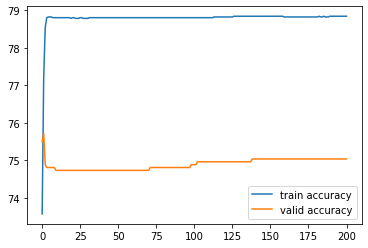

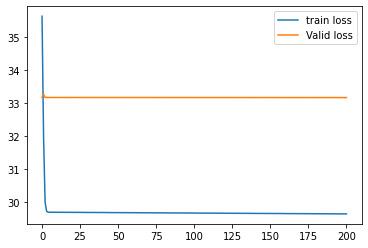

Imputer = median | LR = 6.000000000000001e-05 | Weight decay = 0.01 | Dropout = 0.25 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 35.371 | Training Accuracy: 72.925 | Validation Loss: 32.308 | Validation Accuracy: 76.941
Epoch: 50  | Training Loss: 31.675 | Training Accuracy: 77.304 | Validation Loss: 32.049 | Validation Accuracy: 77.017
Epoch: 100  | Training Loss: 31.659 | Training Accuracy: 77.323 | Validation Loss: 32.045 | Validation Accuracy: 76.941
Epoch: 150  | Training Loss: 31.644 | Training Accuracy: 77.304 | Validation Loss: 32.041 | Validation Accuracy: 76.941
Epoch: 200  | Training Loss: 31.629 | Training Accuracy: 77.323 | Validation Loss: 32.037 | Validation Accuracy: 77.017


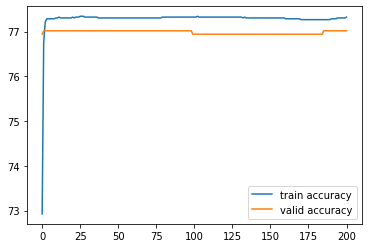

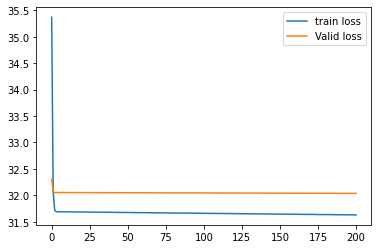

Imputer = most freq | LR = 6.000000000000001e-05 | Weight decay = 0.01 | Dropout = 0.25 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 34.761 | Training Accuracy: 73.781 | Validation Loss: 34.012 | Validation Accuracy: 75.19
Epoch: 50  | Training Loss: 31.016 | Training Accuracy: 78.142 | Validation Loss: 33.934 | Validation Accuracy: 75.266
Epoch: 100  | Training Loss: 31.001 | Training Accuracy: 78.161 | Validation Loss: 33.931 | Validation Accuracy: 75.266
Epoch: 150  | Training Loss: 30.987 | Training Accuracy: 78.161 | Validation Loss: 33.929 | Validation Accuracy: 75.342
Epoch: 200  | Training Loss: 30.973 | Training Accuracy: 78.161 | Validation Loss: 33.926 | Validation Accuracy: 75.342


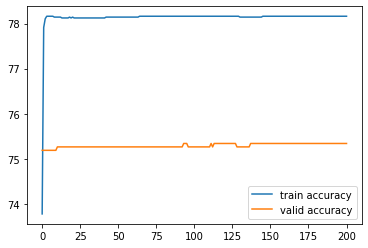

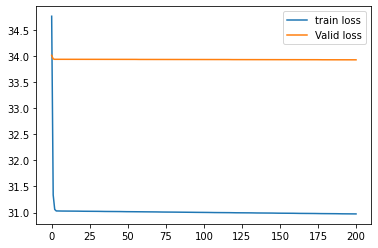

Imputer = mean | LR = 8.5e-05 | Weight decay = 0.1 | Dropout = 0.5 | Layer 1 = 512.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 35.774 | Training Accuracy: 72.677 | Validation Loss: 32.905 | Validation Accuracy: 76.636
Epoch: 50  | Training Loss: 30.702 | Training Accuracy: 77.799 | Validation Loss: 32.667 | Validation Accuracy: 76.256
Epoch: 100  | Training Loss: 30.691 | Training Accuracy: 77.818 | Validation Loss: 32.662 | Validation Accuracy: 76.256
Epoch: 150  | Training Loss: 30.679 | Training Accuracy: 77.799 | Validation Loss: 32.657 | Validation Accuracy: 76.332
Epoch: 200  | Training Loss: 30.668 | Training Accuracy: 77.799 | Validation Loss: 32.652 | Validation Accuracy: 76.332


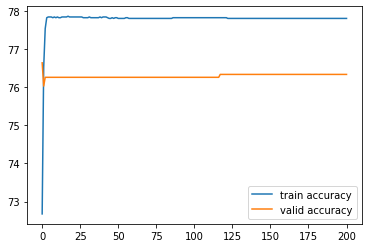

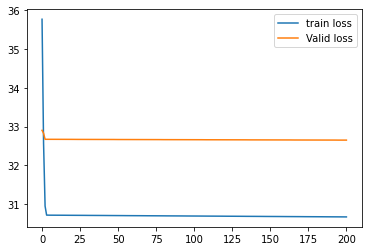

Imputer = median | LR = 8.5e-05 | Weight decay = 0.1 | Dropout = 0.5 | Layer 1 = 512.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 35.587 | Training Accuracy: 73.553 | Validation Loss: 34.043 | Validation Accuracy: 74.505
Epoch: 50  | Training Loss: 30.297 | Training Accuracy: 78.637 | Validation Loss: 34.016 | Validation Accuracy: 74.277
Epoch: 100  | Training Loss: 30.28 | Training Accuracy: 78.656 | Validation Loss: 34.009 | Validation Accuracy: 74.201
Epoch: 150  | Training Loss: 30.263 | Training Accuracy: 78.656 | Validation Loss: 34.002 | Validation Accuracy: 74.125
Epoch: 200  | Training Loss: 30.248 | Training Accuracy: 78.713 | Validation Loss: 33.997 | Validation Accuracy: 74.125


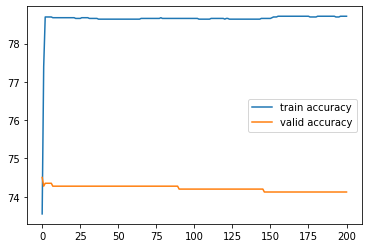

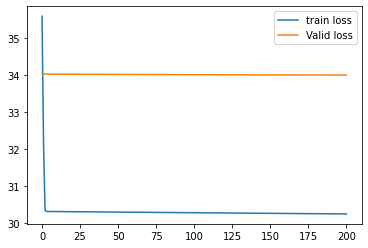

Imputer = most freq | LR = 8.5e-05 | Weight decay = 0.1 | Dropout = 0.5 | Layer 1 = 512.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 36.063 | Training Accuracy: 72.734 | Validation Loss: 33.243 | Validation Accuracy: 76.484
Epoch: 50  | Training Loss: 30.609 | Training Accuracy: 78.027 | Validation Loss: 33.042 | Validation Accuracy: 77.093
Epoch: 100  | Training Loss: 30.593 | Training Accuracy: 78.085 | Validation Loss: 33.041 | Validation Accuracy: 77.169
Epoch: 150  | Training Loss: 30.577 | Training Accuracy: 78.104 | Validation Loss: 33.04 | Validation Accuracy: 77.169
Epoch: 200  | Training Loss: 30.561 | Training Accuracy: 78.085 | Validation Loss: 33.04 | Validation Accuracy: 77.093


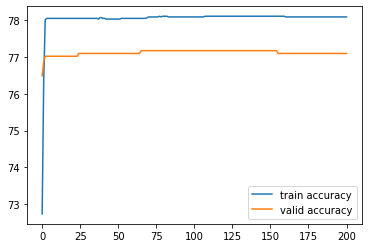

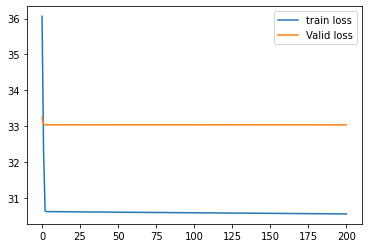

Imputer = mean | LR = 8.5e-05 | Weight decay = 0.01 | Dropout = 0.75 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 36.985 | Training Accuracy: 71.42 | Validation Loss: 35.535 | Validation Accuracy: 72.831
Epoch: 50  | Training Loss: 31.424 | Training Accuracy: 77.513 | Validation Loss: 35.455 | Validation Accuracy: 72.679
Epoch: 100  | Training Loss: 31.407 | Training Accuracy: 77.57 | Validation Loss: 35.453 | Validation Accuracy: 72.679
Epoch: 150  | Training Loss: 31.389 | Training Accuracy: 77.609 | Validation Loss: 35.452 | Validation Accuracy: 72.679
Epoch: 200  | Training Loss: 31.372 | Training Accuracy: 77.685 | Validation Loss: 35.45 | Validation Accuracy: 72.679


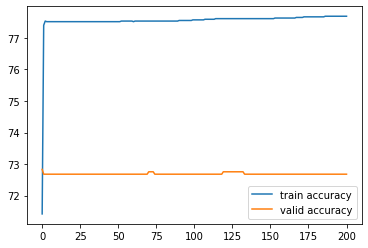

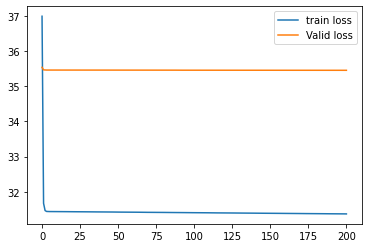

Imputer = median | LR = 8.5e-05 | Weight decay = 0.01 | Dropout = 0.75 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 37.096 | Training Accuracy: 71.154 | Validation Loss: 31.29 | Validation Accuracy: 77.702
Epoch: 50  | Training Loss: 30.702 | Training Accuracy: 78.008 | Validation Loss: 31.105 | Validation Accuracy: 77.397
Epoch: 100  | Training Loss: 30.682 | Training Accuracy: 77.97 | Validation Loss: 31.102 | Validation Accuracy: 77.397
Epoch: 150  | Training Loss: 30.664 | Training Accuracy: 77.989 | Validation Loss: 31.1 | Validation Accuracy: 77.397
Epoch: 200  | Training Loss: 30.646 | Training Accuracy: 78.046 | Validation Loss: 31.098 | Validation Accuracy: 77.473


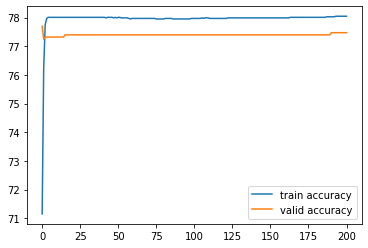

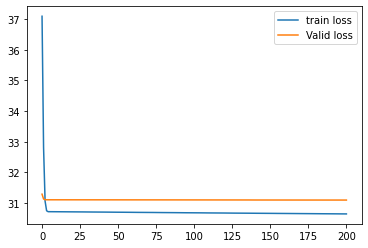

Imputer = most freq | LR = 8.5e-05 | Weight decay = 0.01 | Dropout = 0.75 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 37.068 | Training Accuracy: 71.497 | Validation Loss: 32.259 | Validation Accuracy: 77.245
Epoch: 50  | Training Loss: 30.603 | Training Accuracy: 77.761 | Validation Loss: 32.189 | Validation Accuracy: 77.093
Epoch: 100  | Training Loss: 30.586 | Training Accuracy: 77.761 | Validation Loss: 32.179 | Validation Accuracy: 77.093
Epoch: 150  | Training Loss: 30.569 | Training Accuracy: 77.761 | Validation Loss: 32.171 | Validation Accuracy: 77.093
Epoch: 200  | Training Loss: 30.552 | Training Accuracy: 77.761 | Validation Loss: 32.162 | Validation Accuracy: 77.017


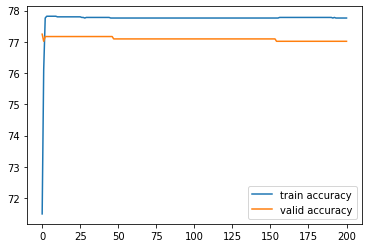

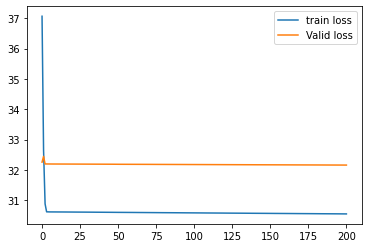

Imputer = mean | LR = 0.00011000000000000002 | Weight decay = 0.001 | Dropout = 0.5 | Layer 1 = 256.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 35.521 | Training Accuracy: 73.382 | Validation Loss: 34.483 | Validation Accuracy: 75.266
Epoch: 50  | Training Loss: 30.872 | Training Accuracy: 77.97 | Validation Loss: 34.277 | Validation Accuracy: 74.658
Epoch: 100  | Training Loss: 30.862 | Training Accuracy: 77.951 | Validation Loss: 34.274 | Validation Accuracy: 74.658
Epoch: 150  | Training Loss: 30.852 | Training Accuracy: 77.951 | Validation Loss: 34.271 | Validation Accuracy: 74.734
Epoch: 200  | Training Loss: 30.842 | Training Accuracy: 77.932 | Validation Loss: 34.269 | Validation Accuracy: 74.734


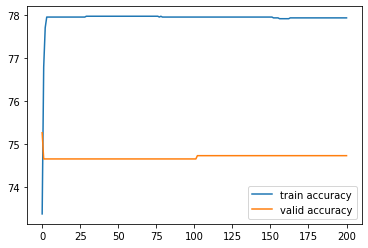

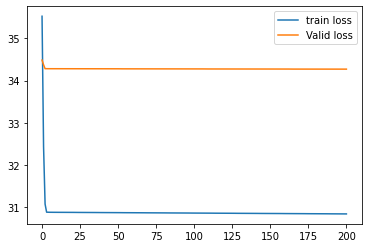

Imputer = median | LR = 0.00011000000000000002 | Weight decay = 0.001 | Dropout = 0.5 | Layer 1 = 256.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 36.007 | Training Accuracy: 72.372 | Validation Loss: 34.532 | Validation Accuracy: 74.886
Epoch: 50  | Training Loss: 30.925 | Training Accuracy: 78.237 | Validation Loss: 34.179 | Validation Accuracy: 74.353
Epoch: 100  | Training Loss: 30.916 | Training Accuracy: 78.237 | Validation Loss: 34.175 | Validation Accuracy: 74.353
Epoch: 150  | Training Loss: 30.906 | Training Accuracy: 78.237 | Validation Loss: 34.17 | Validation Accuracy: 74.429
Epoch: 200  | Training Loss: 30.897 | Training Accuracy: 78.313 | Validation Loss: 34.165 | Validation Accuracy: 74.505


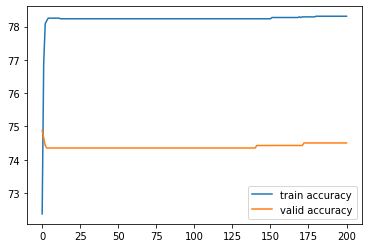

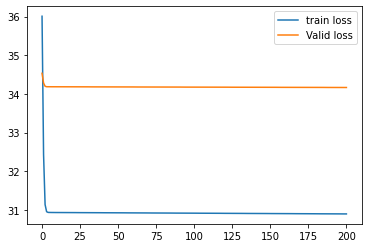

Imputer = most freq | LR = 0.00011000000000000002 | Weight decay = 0.001 | Dropout = 0.5 | Layer 1 = 256.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 36.001 | Training Accuracy: 73.058 | Validation Loss: 33.135 | Validation Accuracy: 76.484
Epoch: 50  | Training Loss: 31.411 | Training Accuracy: 77.551 | Validation Loss: 33.123 | Validation Accuracy: 76.104
Epoch: 100  | Training Loss: 31.4 | Training Accuracy: 77.609 | Validation Loss: 33.114 | Validation Accuracy: 76.104
Epoch: 150  | Training Loss: 31.388 | Training Accuracy: 77.628 | Validation Loss: 33.106 | Validation Accuracy: 76.104
Epoch: 200  | Training Loss: 31.377 | Training Accuracy: 77.647 | Validation Loss: 33.098 | Validation Accuracy: 76.18


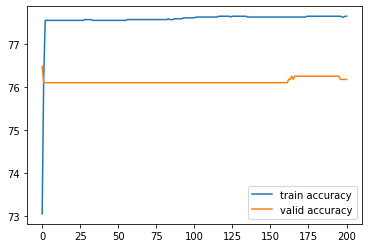

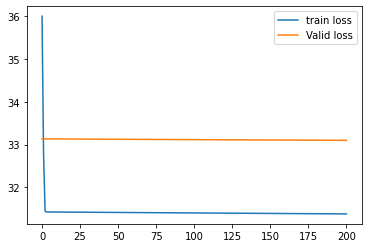

Imputer = mean | LR = 8.5e-05 | Weight decay = 0.1 | Dropout = 0.75 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 36.544 | Training Accuracy: 72.353 | Validation Loss: 33.134 | Validation Accuracy: 76.18
Epoch: 50  | Training Loss: 31.924 | Training Accuracy: 77.304 | Validation Loss: 33.072 | Validation Accuracy: 75.875
Epoch: 100  | Training Loss: 31.902 | Training Accuracy: 77.342 | Validation Loss: 33.071 | Validation Accuracy: 75.951
Epoch: 150  | Training Loss: 31.881 | Training Accuracy: 77.361 | Validation Loss: 33.069 | Validation Accuracy: 75.951
Epoch: 200  | Training Loss: 31.86 | Training Accuracy: 77.399 | Validation Loss: 33.068 | Validation Accuracy: 76.104


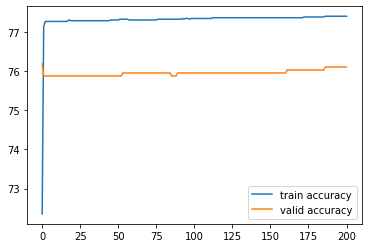

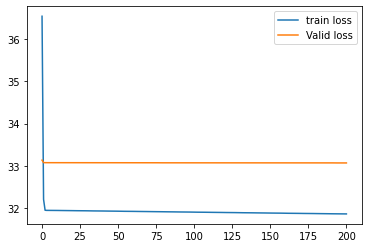

Imputer = median | LR = 8.5e-05 | Weight decay = 0.1 | Dropout = 0.75 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 36.58 | Training Accuracy: 72.525 | Validation Loss: 34.22 | Validation Accuracy: 74.581
Epoch: 50  | Training Loss: 30.201 | Training Accuracy: 78.313 | Validation Loss: 33.911 | Validation Accuracy: 74.734
Epoch: 100  | Training Loss: 30.18 | Training Accuracy: 78.256 | Validation Loss: 33.907 | Validation Accuracy: 74.81
Epoch: 150  | Training Loss: 30.16 | Training Accuracy: 78.313 | Validation Loss: 33.904 | Validation Accuracy: 74.886
Epoch: 200  | Training Loss: 30.14 | Training Accuracy: 78.389 | Validation Loss: 33.901 | Validation Accuracy: 74.658


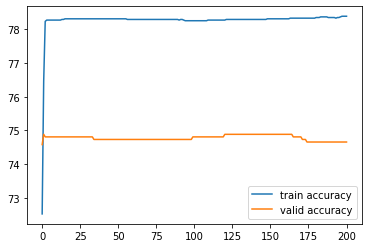

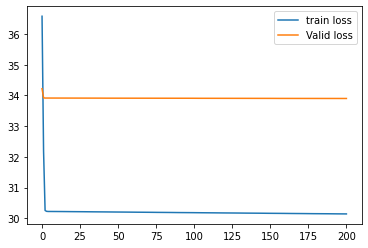

Imputer = most freq | LR = 8.5e-05 | Weight decay = 0.1 | Dropout = 0.75 | Layer 1 = 1024.0 | Layer 2 = 256 | Batch size = 64.0

Epoch: 0  | Training Loss: 36.764 | Training Accuracy: 72.22 | Validation Loss: 34.239 | Validation Accuracy: 74.277
Epoch: 50  | Training Loss: 30.239 | Training Accuracy: 78.465 | Validation Loss: 33.653 | Validation Accuracy: 75.19
Epoch: 100  | Training Loss: 30.204 | Training Accuracy: 78.484 | Validation Loss: 33.647 | Validation Accuracy: 75.114
Epoch: 150  | Training Loss: 30.171 | Training Accuracy: 78.446 | Validation Loss: 33.644 | Validation Accuracy: 75.19
Epoch: 200  | Training Loss: 30.141 | Training Accuracy: 78.465 | Validation Loss: 33.642 | Validation Accuracy: 75.114


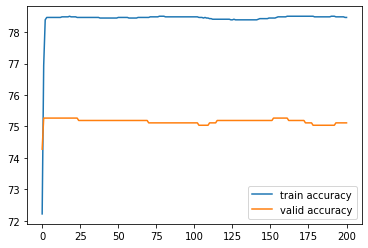

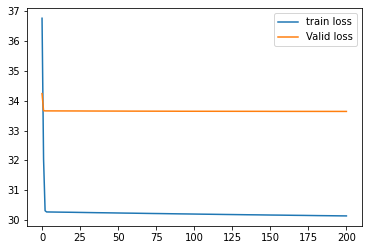

In [ ]:
imputations = ['mean', 'median', 'most freq']
total_best_results = []
best_models = []
# Get best 5 models
best_hyper = df.sort_values(by=['Val loss']).values[:5]

for mod, lr, wd, dropout1, neurons1, bs, tr_l, tr_ac, val_l, val_ac in best_hyper:
  for imp in imputations:

    print('Imputer =', imp, '| LR =', lr, '| Weight decay =', wd, '| Dropout =', dropout1,
        '| Layer 1 =', neurons1, '| Layer 2 =', neurons2, '| Batch size =', bs)
    print()
    
    # Get training and validation sets
    train, validation, test = get_split_tensors(add=True, method=imp, ts=0.2)

    model = Neural_Network(training_data.iloc[:,1:-1].values, int(neurons1), 
                            neurons2, dropout1, dropout2, two_layers=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    criterion = nn.BCELoss()

    epochs = 200

    train_acc, train_losses, valid_acc, valid_losses = model.train(train, validation,
                                                                  int(bs), optimizer, 
                                                                  scheduler, 
                                                                  criterion, 
                                                                  epochs, 50)

    total_best_results.append((trained_model, imp, lr, wd, dropout1, neurons1, bs, min(train_losses),
                    max(train_acc), min(valid_losses), max(valid_acc)))
    best_models.append(model)

Observe best models using Pandas Dataframe

In [ ]:
cols = ['Imputation', 'Learning rate', 'Weight decay', 'Dropout', 'Neurons hidden',
        'Batch size', 'Train loss', 'Train accuracy', 'Val loss', 'Val accuracy']

df = pd.DataFrame(total_best_results, columns=cols)
best = df.sort_values(by=['Val loss'])[:10]
best

,Imputation,Learning rate,Weight decay,Dropout,Neurons hidden,Batch size,Train loss,Train accuracy,Val loss,Val accuracy
7,median,0.000085,0.010,0.75,1024.0,64.0,30.646,78.046,31.098,77.702
1,median,0.000060,0.010,0.25,1024.0,64.0,31.629,77.342,32.037,77.017
8,most freq,0.000085,0.010,0.75,1024.0,64.0,30.552,77.818,32.162,77.245
3,mean,0.000085,0.100,0.50,512.0,64.0,30.668,77.856,32.652,76.636
5,most freq,0.000085,0.100,0.50,512.0,64.0,30.561,78.104,33.040,77.169
12,mean,0.000085,0.100,0.75,1024.0,64.0,31.860,77.399,33.068,76.180
11,most freq,0.000110,0.001,0.50,256.0,64.0,31.377,77.647,33.098,76.484
0,mean,0.000060,0.010,0.25,1024.0,64.0,29.635,78.846,33.167,75.723
14,most freq,0.000085,0.100,0.75,1024.0,64.0,30.141,78.503,33.642,75.266
13,median,0.000085,0.100,0.75,1024.0,64.0,30.140,78.389,33.901,74.886


Get predictions for best model

In [ ]:
best_model = best_models[7]

In [ ]:
predictions = best_model.predict(test.to('cuda:0'))

In [ ]:
preds = torch.where(predictions > 0.5, 1, 0)

Save results in a CSV file

In [ ]:
results_directory = "/content/drive/My Drive/Sussex AI/Spring Semester/Machine Learning/Kaggle Competition/"

In [ ]:
# Save results in a csv file
with open(os.path.join(results_directory, 'Kaggle_submisison_file.csv'), 'w') as out:
  writer = csv.writer(out, delimiter=',')
  writer.writerow(['ID', 'prediction'])
  for i in range(len(preds)):
    writer.writerow([str(i+1), preds[i].item()])

# Other Discarded Models

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Grid search for Suport Vector Machine Classifier

In [ ]:
# Training se
param_grid = {'C': [0.001, 0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'poly']} 
  
grid_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose=3)
  
# fitting the model for grid search
grid_svm.fit(X_train, y_train.reshape(len(y_train)))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.533, total=   1.7s
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.543, total=   1.7s
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.543, total=   1.7s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.543, total=   1.6s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.543, total=   1.6s
[CV] C=0.001, gamma=1, kernel=sigmoid ................................
[CV] .... C=0.001, gamma=1, kernel=sigmoid, score=0.533, total=   1.5s
[CV] C=0.001, gamma=1, kernel=sigmoid ................................
[CV] .... C=0.001, gamma=1, kernel=sigmoid, score=0.543, total=   1.5s
[CV] C=0.001, gamma=1, kernel=sigmoid ................................
[CV] .... C=0.001, gamma=1, kernel=sigmoid, score=0.543, total=   1.5s
[CV] C=0.001, gamma=1, kernel=sigmoid ................................
[CV] .... C=0.001, gamma=1, kernel=sigmoid, score=0.543, total=   1.5s
[CV] C=0.001, gamma=1, kernel=sigmoid ................................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:  9.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
# print best parameter after tuning
print(grid_svm.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_svm.best_estimator_)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
predictions_svm = grid_svm.predict(X_val)

In [ ]:
print('Accuracy of SVM: ', np.sum(predictions_svm == y_val.reshape(len(y_val))) / len(y_val) * 100)

Accuracy of SVM:  72.72727272727273


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

Grid search for Logistic Regression

In [ ]:
# Training se
param_grid = {"C":np.logspace(-10,10,10), "penalty":["l1","l2"],
              'solver': ['lbfgs', 'newton-cg', '‘sag’']}
  
grid_lr = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose=3)
  
# fitting the model for grid search
grid_lr.fit(X_train, y_train.reshape(len(y_train)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=1e-10, penalty=l1, solver=lbfgs ...............................
[CV] ..... C=1e-10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l1, solver=lbfgs ...............................
[CV] ..... C=1e-10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l1, solver=lbfgs ...............................
[CV] ..... C=1e-10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l1, solver=lbfgs ...............................
[CV] ..... C=1e-10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l1, solver=lbfgs ...............................
[CV] ..... C=1e-10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l1, solver=newton-cg ...........................
[CV] . C=1e-10, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l1, solver=newton-cg ...........................
[CV] . C=1e-10,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. Th

[CV] ... C=1e-10, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=1e-10, penalty=l2, solver=lbfgs ...............................
[CV] ... C=1e-10, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=1e-10, penalty=l2, solver=lbfgs ...............................
[CV] ... C=1e-10, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=1e-10, penalty=l2, solver=lbfgs ...............................
[CV] ... C=1e-10, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=1e-10, penalty=l2, solver=newton-cg ...........................
[CV]  C=1e-10, penalty=l2, solver=newton-cg, score=0.533, total=   0.2s
[CV] C=1e-10, penalty=l2, solver=newton-cg ...........................


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV]  C=1e-10, penalty=l2, solver=newton-cg, score=0.543, total=   0.3s
[CV] C=1e-10, penalty=l2, solver=newton-cg ...........................


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV]  C=1e-10, penalty=l2, solver=newton-cg, score=0.543, total=   0.3s
[CV] C=1e-10, penalty=l2, solver=newton-cg ...........................
[CV]  C=1e-10, penalty=l2, solver=newton-cg, score=0.543, total=   0.1s
[CV] C=1e-10, penalty=l2, solver=newton-cg ...........................
[CV]  C=1e-10, penalty=l2, solver=newton-cg, score=0.543, total=   0.2s
[CV] C=1e-10, penalty=l2, solver=‘sag’ ...............................
[CV] ..... C=1e-10, penalty=l2, solver=‘sag’, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l2, solver=‘sag’ ...............................
[CV] ..... C=1e-10, penalty=l2, solver=‘sag’, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l2, solver=‘sag’ ...............................
[CV] ..... C=1e-10, penalty=l2, solver=‘sag’, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l2, solver=‘sag’ ...............................
[CV] ..... C=1e-10, penalty=l2, solver=‘sag’, score=nan, total=   0.0s
[CV] C=1e-10, penalty=l2, solver=‘sag’ ...............................
[CV

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=1.6681005372000592e-08, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=1.6681005372000592e-08, penalty=l2, solver=lbfgs ..............
[CV]  C=1.6681005372000592e-08, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=1.6681005372000592e-08, penalty=l2, solver=lbfgs ..............
[CV]  C=1.6681005372000592e-08, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=1.6681005372000592e-08, penalty=l2, solver=lbfgs ..............
[CV]  C=1.6681005372000592e-08, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=1.6681005372000592e-08, penalty=l2, solver=newton-cg ..........
[CV]  C=1.6681005372000592e-08, penalty=l2, solver=newton-cg, score=0.533, total=   0.2s
[CV] C=1.6681005372000592e-08, penalty=l2, solver=newton-cg ..........
[CV]  C=1.6681005372000592e-08, penalty=l2, solver=newton-cg, score=0.543, total=   0.2s
[CV] C=1.6681005372000592e-08, penalty=l2, solver=newton-cg ..........
[CV]  C=1.6681005372000592e-08, penalty=l2, solver=newto

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=2.782559402207126e-06, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=2.782559402207126e-06, penalty=l2, solver=lbfgs ...............
[CV]  C=2.782559402207126e-06, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=2.782559402207126e-06, penalty=l2, solver=lbfgs ...............
[CV]  C=2.782559402207126e-06, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=2.782559402207126e-06, penalty=l2, solver=lbfgs ...............
[CV]  C=2.782559402207126e-06, penalty=l2, solver=lbfgs, score=0.543, total=   0.1s
[CV] C=2.782559402207126e-06, penalty=l2, solver=newton-cg ...........
[CV]  C=2.782559402207126e-06, penalty=l2, solver=newton-cg, score=0.533, total=   0.1s
[CV] C=2.782559402207126e-06, penalty=l2, solver=newton-cg ...........
[CV]  C=2.782559402207126e-06, penalty=l2, solver=newton-cg, score=0.543, total=   0.1s
[CV] C=2.782559402207126e-06, penalty=l2, solver=newton-cg ...........
[CV]  C=2.782559402207126e-06, penalty=l2, solver=newton-cg, s

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=0.0004641588833612782, penalty=l2, solver=lbfgs, score=0.752, total=   0.1s
[CV] C=0.0004641588833612782, penalty=l2, solver=lbfgs ...............
[CV]  C=0.0004641588833612782, penalty=l2, solver=lbfgs, score=0.686, total=   0.1s
[CV] C=0.0004641588833612782, penalty=l2, solver=lbfgs ...............
[CV]  C=0.0004641588833612782, penalty=l2, solver=lbfgs, score=0.657, total=   0.1s
[CV] C=0.0004641588833612782, penalty=l2, solver=lbfgs ...............
[CV]  C=0.0004641588833612782, penalty=l2, solver=lbfgs, score=0.743, total=   0.1s
[CV] C=0.0004641588833612782, penalty=l2, solver=newton-cg ...........
[CV]  C=0.0004641588833612782, penalty=l2, solver=newton-cg, score=0.724, total=   0.2s
[CV] C=0.0004641588833612782, penalty=l2, solver=newton-cg ...........
[CV]  C=0.0004641588833612782, penalty=l2, solver=newton-cg, score=0.752, total=   0.2s
[CV] C=0.0004641588833612782, penalty=l2, solver=newton-cg ...........
[CV]  C=0.0004641588833612782, penalty=l2, solver=newton-cg, s

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=0.07742636826811278, penalty=l2, solver=lbfgs, score=0.800, total=   0.2s
[CV] C=0.07742636826811278, penalty=l2, solver=lbfgs .................
[CV]  C=0.07742636826811278, penalty=l2, solver=lbfgs, score=0.714, total=   0.2s
[CV] C=0.07742636826811278, penalty=l2, solver=lbfgs .................
[CV]  C=0.07742636826811278, penalty=l2, solver=lbfgs, score=0.733, total=   0.2s
[CV] C=0.07742636826811278, penalty=l2, solver=lbfgs .................
[CV]  C=0.07742636826811278, penalty=l2, solver=lbfgs, score=0.705, total=   0.2s
[CV] C=0.07742636826811278, penalty=l2, solver=lbfgs .................
[CV]  C=0.07742636826811278, penalty=l2, solver=lbfgs, score=0.743, total=   0.2s
[CV] C=0.07742636826811278, penalty=l2, solver=newton-cg .............
[CV]  C=0.07742636826811278, penalty=l2, solver=newton-cg, score=0.800, total=   0.4s
[CV] C=0.07742636826811278, penalty=l2, solver=newton-cg .............
[CV]  C=0.07742636826811278, penalty=l2, solver=newton-cg, score=0.714, total=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/l

[CV]  C=12.915496650148826, penalty=l2, solver=lbfgs, score=0.714, total=   0.3s
[CV] C=12.915496650148826, penalty=l2, solver=lbfgs ..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=12.915496650148826, penalty=l2, solver=lbfgs, score=0.638, total=   0.3s
[CV] C=12.915496650148826, penalty=l2, solver=lbfgs ..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=12.915496650148826, penalty=l2, solver=lbfgs, score=0.724, total=   0.3s
[CV] C=12.915496650148826, penalty=l2, solver=lbfgs ..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=12.915496650148826, penalty=l2, solver=lbfgs, score=0.657, total=   0.3s
[CV] C=12.915496650148826, penalty=l2, solver=lbfgs ..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=12.915496650148826, penalty=l2, solver=lbfgs, score=0.695, total=   0.3s
[CV] C=12.915496650148826, penalty=l2, solver=newton-cg ..............
[CV]  C=12.915496650148826, penalty=l2, solver=newton-cg, score=0.724, total=   0.5s
[CV] C=12.915496650148826, penalty=l2, solver=newton-cg ..............
[CV]  C=12.915496650148826, penalty=l2, solver=newton-cg, score=0.648, total=   0.6s
[CV] C=12.915496650148826, penalty=l2, solver=newton-cg ..............
[CV]  C=12.915496650148826, penalty=l2, solver=newton-cg, score=0.724, total=   0.6s
[CV] C=12.915496650148826, penalty=l2, solver=newton-cg ..............
[CV]  C=12.915496650148826, penalty=l2, solver=newton-cg, score=0.657, total=   0.5s
[CV] C=12.915496650148826, penalty=l2, solver=newton-cg ..............
[CV]  C=12.915496650148826, penalty=l2, solver=newton-cg, score=0.686, total=   0.5s
[CV] C=12.915496650148826, penalty=l2, solver=‘sag’ ..................
[CV]  C=12.915496650148826, penalty=l2, solver=‘sag’, score=nan, tot

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/l

[CV]  C=2154.4346900318865, penalty=l2, solver=lbfgs, score=0.705, total=   0.3s
[CV] C=2154.4346900318865, penalty=l2, solver=lbfgs ..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=2154.4346900318865, penalty=l2, solver=lbfgs, score=0.629, total=   0.3s
[CV] C=2154.4346900318865, penalty=l2, solver=lbfgs ..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=2154.4346900318865, penalty=l2, solver=lbfgs, score=0.714, total=   0.3s
[CV] C=2154.4346900318865, penalty=l2, solver=lbfgs ..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=2154.4346900318865, penalty=l2, solver=lbfgs, score=0.657, total=   0.3s
[CV] C=2154.4346900318865, penalty=l2, solver=lbfgs ..................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=2154.4346900318865, penalty=l2, solver=lbfgs, score=0.686, total=   0.3s
[CV] C=2154.4346900318865, penalty=l2, solver=newton-cg ..............
[CV]  C=2154.4346900318865, penalty=l2, solver=newton-cg, score=0.714, total=   0.4s
[CV] C=2154.4346900318865, penalty=l2, solver=newton-cg ..............
[CV]  C=2154.4346900318865, penalty=l2, solver=newton-cg, score=0.629, total=   0.5s
[CV] C=2154.4346900318865, penalty=l2, solver=newton-cg ..............
[CV]  C=2154.4346900318865, penalty=l2, solver=newton-cg, score=0.724, total=   0.6s
[CV] C=2154.4346900318865, penalty=l2, solver=newton-cg ..............
[CV]  C=2154.4346900318865, penalty=l2, solver=newton-cg, score=0.657, total=   0.5s
[CV] C=2154.4346900318865, penalty=l2, solver=newton-cg ..............
[CV]  C=2154.4346900318865, penalty=l2, solver=newton-cg, score=0.676, total=   0.6s
[CV] C=2154.4346900318865, penalty=l2, solver=‘sag’ ..................
[CV]  C=2154.4346900318865, penalty=l2, solver=‘sag’, score=nan, tot

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=359381.36638046405, penalty=l2, solver=lbfgs, score=0.695, total=   0.1s
[CV] C=359381.36638046405, penalty=l2, solver=lbfgs ..................
[CV]  C=359381.36638046405, penalty=l2, solver=lbfgs, score=0.629, total=   0.1s
[CV] C=359381.36638046405, penalty=l2, solver=lbfgs ..................
[CV]  C=359381.36638046405, penalty=l2, solver=lbfgs, score=0.714, total=   0.1s
[CV] C=359381.36638046405, penalty=l2, solver=lbfgs ..................
[CV]  C=359381.36638046405, penalty=l2, solver=lbfgs, score=0.619, total=   0.1s
[CV] C=359381.36638046405, penalty=l2, solver=lbfgs ..................
[CV]  C=359381.36638046405, penalty=l2, solver=lbfgs, score=0.695, total=   0.1s
[CV] C=359381.36638046405, penalty=l2, solver=newton-cg ..............
[CV]  C=359381.36638046405, penalty=l2, solver=newton-cg, score=0.705, total=   0.3s
[CV] C=359381.36638046405, penalty=l2, solver=newton-cg ..............
[CV]  C=359381.36638046405, penalty=l2, solver=newton-cg, score=0.629, total=   0.4s

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=59948425.03189421, penalty=l2, solver=lbfgs, score=0.695, total=   0.1s
[CV] C=59948425.03189421, penalty=l2, solver=lbfgs ...................
[CV]  C=59948425.03189421, penalty=l2, solver=lbfgs, score=0.619, total=   0.1s
[CV] C=59948425.03189421, penalty=l2, solver=lbfgs ...................
[CV]  C=59948425.03189421, penalty=l2, solver=lbfgs, score=0.705, total=   0.1s
[CV] C=59948425.03189421, penalty=l2, solver=lbfgs ...................
[CV]  C=59948425.03189421, penalty=l2, solver=lbfgs, score=0.619, total=   0.1s
[CV] C=59948425.03189421, penalty=l2, solver=lbfgs ...................
[CV]  C=59948425.03189421, penalty=l2, solver=lbfgs, score=0.695, total=   0.1s
[CV] C=59948425.03189421, penalty=l2, solver=newton-cg ...............
[CV]  C=59948425.03189421, penalty=l2, solver=newton-cg, score=0.705, total=   0.3s
[CV] C=59948425.03189421, penalty=l2, solver=newton-cg ...............
[CV]  C=59948425.03189421, penalty=l2, solver=newton-cg, score=0.629, total=   0.4s
[CV] C

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=10000000000.0, penalty=l2, solver=lbfgs, score=0.695, total=   0.1s
[CV] C=10000000000.0, penalty=l2, solver=lbfgs .......................
[CV]  C=10000000000.0, penalty=l2, solver=lbfgs, score=0.619, total=   0.1s
[CV] C=10000000000.0, penalty=l2, solver=lbfgs .......................
[CV]  C=10000000000.0, penalty=l2, solver=lbfgs, score=0.705, total=   0.1s
[CV] C=10000000000.0, penalty=l2, solver=lbfgs .......................
[CV]  C=10000000000.0, penalty=l2, solver=lbfgs, score=0.619, total=   0.1s
[CV] C=10000000000.0, penalty=l2, solver=lbfgs .......................
[CV]  C=10000000000.0, penalty=l2, solver=lbfgs, score=0.695, total=   0.1s
[CV] C=10000000000.0, penalty=l2, solver=newton-cg ...................
[CV]  C=10000000000.0, penalty=l2, solver=newton-cg, score=0.705, total=   0.4s
[CV] C=10000000000.0, penalty=l2, solver=newton-cg ...................
[CV]  C=10000000000.0, penalty=l2, solver=newton-cg, score=0.629, total=   0.4s
[CV] C=10000000000.0, penalty=l2, 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   24.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-10, 1.66810054e-08, 2.78255940e-06, 4.64158883e-04,
       7.74263683e-02, 1.29154967e+01, 2.15443469e+03, 3.59381366e+05,
       5.99484250e+07, 1.00000000e+10]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', '‘sag’']},
             pre_

In [ ]:
# print best parameter after tuning
print(grid_lr.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_lr.best_estimator_)

{'C': 0.07742636826811278, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression(C=0.07742636826811278, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
prediction_val_lr = grid_lr.predict(X_val)
np.sum(prediction_val_lr == y_val.reshape(len(y_val))) / len(y_val) * 100

74.24242424242425

In [ ]:
prediction_lr = grid_lr.predict(features_test_array)

(4502, array([0, 1, 0, ..., 1, 1, 1]))